In [1]:
!pip install pandas


In [2]:
import os
import pandas as pd
import numpy as np

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
# !pip install pydub
from pydub import AudioSegment, effects
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use('ggplot')

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

C:\Users\Vaibhav Tiwari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
from keras.models import load_model

load_model_annlstm = load_model("ann_lstm.h5")
loaded_model_cnnattention = load_model("cnn-attention-model.h5")
loaded_modelcnn = load_model("cnn-model.h5")
load_model_annmorelstm = load_model("ann_more_lstm.h5")
load_model_cnnlstm = load_model("cnn_lstm.h5")
load_model_ann = load_model("ann-model.h5")
load_model_more_ann = load_model("more-ann.h5")

In [4]:
import os

# specify the path to the directory containing the files
directory = 'Savee'

# loop over all files in the directory
for filename in os.listdir(directory):
    # check if the filename contains the substring "sa"
    if "sa" in filename:
        # construct the new filename
        new_filename = filename.replace("sa", "s")
        # construct the full paths for the old and new filenames
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        # rename the file
        os.rename(old_path, new_path)

    # check if the filename contains the substring "su"
    if "su" in filename:
        # construct the full path to the file
        file_path = os.path.join(directory, filename)
        # delete the file
        os.remove(file_path)

In [5]:
file_path_list = []
gender_list = []
emotion_label_list = []
savee_path = "./Savee"

emotion_dictionary = {
    "a" : "angry",
    "d" : "disgust",
    "f" : "fear" , 
    "s" : "sad" , 
    "h" : "happy"
}


for audio_file in os.listdir(savee_path):
    file_name_parts = audio_file.split('.')[0].split('_')[1][0]
    if file_name_parts == "n":
        pass
    else:
        key = emotion_dictionary[file_name_parts]
        file_path_list.append(f"{savee_path}/{audio_file}")
        gender_list.append('male')
        emotion_label_list.append(key)

savee_dataframe = pd.DataFrame({
    'file_path': file_path_list,
    'gender_category': gender_list,
    'emotion_label': emotion_label_list
})

savee_dataframe.head()

,file_path,gender_category,emotion_label
0,./Savee/DC_a01.wav,male,angry
1,./Savee/DC_a02.wav,male,angry
2,./Savee/DC_a03.wav,male,angry
3,./Savee/DC_a04.wav,male,angry
4,./Savee/DC_a05.wav,male,angry


In [6]:
# data augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=4)

# taking any example and checking for techniques.
path = np.array(savee_dataframe.file_path)[1]
data, sample_rate = librosa.load(path)

In [7]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # spectral_centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data).T, axis=0)
    result = np.hstack((result, spectral_centroid)) # stacking horizontally

    # spectral_bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data).T, axis=0)
    result = np.hstack((result, spectral_bandwidth)) # stacking horizontally

    # spectral_contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data).T, axis=0)
    result = np.hstack((result, spectral_contrast)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
X_test, Y_test = [], []
for path, emotion in zip(savee_dataframe.file_path, savee_dataframe.emotion_label):
    feature = get_features(path)
    for ele in feature:
        X_test.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y_test.append(emotion)

In [9]:
Features = pd.DataFrame(X_test)
Features['labels'] = Y_test
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,labels
0,0.038891,0.167045,1089.103210,1068.182025,30.325378,19.403687,21.866991,19.155308,22.740866,19.702703,...,0.000008,0.000002,0.000001,0.000001,0.000001,9.651800e-07,8.815933e-07,6.204343e-07,1.810680e-07,angry
1,0.119168,0.170834,3496.259941,3312.916249,22.550501,18.115295,18.219047,13.856100,14.526487,13.633440,...,0.067416,0.066189,0.067774,0.068030,0.068162,6.305952e-02,6.672249e-02,6.933680e-02,6.934975e-02,angry
2,0.043240,0.090050,1291.493472,1402.224756,34.419542,19.998377,21.983939,21.910990,21.654478,25.673628,...,0.000152,0.000090,0.000121,0.000130,0.000083,5.204850e-05,2.203961e-05,8.347804e-06,3.317978e-07,angry
3,0.033904,0.158818,1059.449893,1117.709834,30.483110,19.709231,20.306943,18.802990,21.573450,19.994558,...,0.000092,0.000085,0.000075,0.000069,0.000061,5.409915e-05,4.848720e-05,3.427215e-05,8.903367e-06,angry
4,0.041956,0.159210,2256.636834,2609.152355,26.536245,18.695234,19.192491,16.647374,17.651331,13.731760,...,0.005367,0.005315,0.005493,0.005332,0.005212,5.162446e-03,5.246771e-03,5.218584e-03,5.407040e-03,angry


In [10]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [11]:
X.shape

(900, 164)

In [12]:
# As this is a multiclass classification problem onehotencoding our Y.
import pickle

encoder_path = "./encoder"
with open(encoder_path, 'rb') as encoder_file:
    encoder = pickle.load(encoder_file)
    
Y = encoder.transform(np.array(Y).reshape(-1,1)).toarray()


In [13]:
scalar_path = "./scalar"
with open(scalar_path, 'rb') as scalar_file:
    scalar = pickle.load(scalar_file)
    
X = scalar.fit_transform(X)
# making our data compatible to model.
X  = np.expand_dims(X, axis=2)

In [14]:
X,Y

(array([[[-0.33716273],
         [ 0.78296142],
         [-0.65077899],
         ...,
         [-0.35921858],
         [-0.35782909],
         [-0.35842616]],
 
        [[ 1.33772021],
         [ 0.82919382],
         [ 1.85488527],
         ...,
         [ 4.04141019],
         [ 4.22679835],
         [ 4.25552179]],
 
        [[-0.24641946],
         [-0.15654466],
         [-0.44010636],
         ...,
         [-0.3578231 ],
         [-0.35731814],
         [-0.35841613]],
 
        ...,
 
        [[-0.95142482],
         [-1.18626852],
         [-0.97339152],
         ...,
         [-0.35927506],
         [-0.35786876],
         [-0.35843755]],
 
        [[-0.95142482],
         [-1.18626846],
         [-0.854744  ],
         ...,
         [-0.35927268],
         [-0.35786621],
         [-0.35843494]],
 
        [[-0.98127011],
         [-1.20762947],
         [-0.95420665],
         ...,
         [-0.35927409],
         [-0.35786934],
         [-0.35843807]]]),
 array([[1., 0., 0.

In [15]:
X.shape

(900, 164, 1)

# CNN

29/29 [==============================] - 1s 12ms/step
[[1.99067593e-02 6.67731452e-04 4.40214435e-03 9.75003481e-01
  1.98778089e-05]
 [9.99975681e-01 2.54950965e-06 1.35319451e-05 8.07731249e-06
  9.90490392e-08]
 [3.20027029e-05 3.52850737e-04 8.04001029e-05 2.54543829e-05
  9.99509215e-01]
 ...
 [2.28059348e-02 7.02464301e-03 1.02337925e-02 1.06006954e-02
  9.49334919e-01]
 [1.38645202e-01 1.84761435e-01 3.57044965e-01 1.61040545e-01
  1.58507854e-01]
 [7.52362013e-01 4.05491441e-02 9.09704017e-04 2.05677509e-01
  5.01497707e-04]]
29/29 [==============================] - 0s 12ms/step


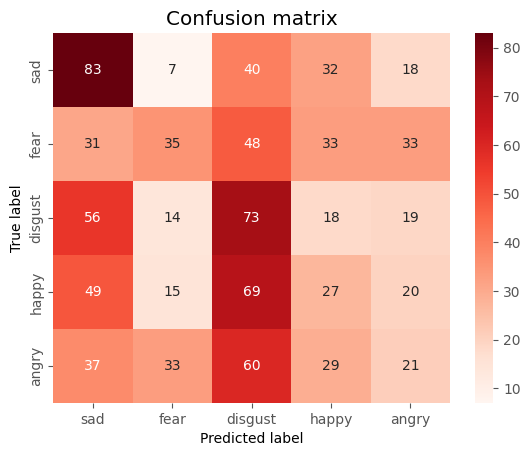

In [16]:
##CNN
print(loaded_model_cnnattention.predict(X))
y_pred = np.argmax(loaded_model_cnnattention.predict(X), axis=1)
y_true = np.argmax(Y, axis=1)
labels = ['sad', 'fear', 'disgust', 'happy', 'angry']
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

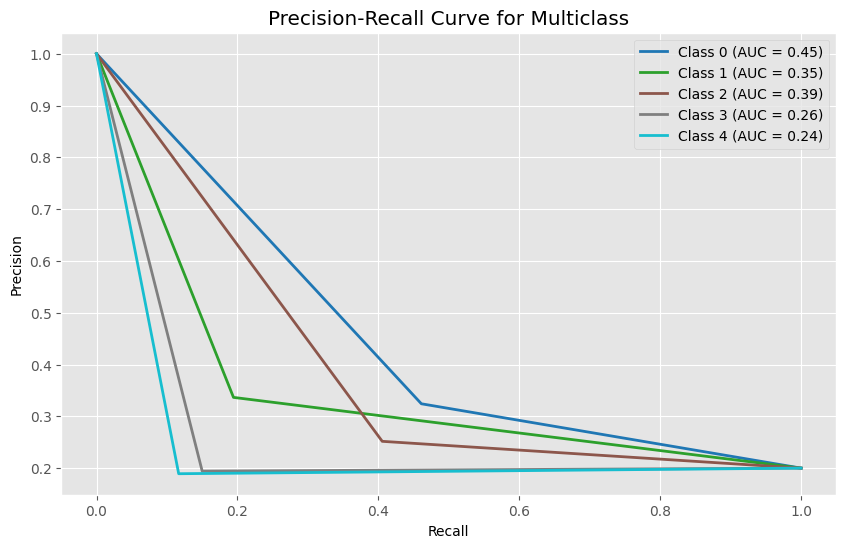

In [17]:
# plot precison recall metrices for cnn attention model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


# Example data (replace this with your actual data)
y_true = np.array(y_true)
y_scores = np.array(y_pred)

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
average_precision = dict()

n_classes = y_true_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

accuracy

0.26555555555555554

# Combo of CNN AND LSTM

29/29 [==============================] - 1s 9ms/step
[[8.68027389e-01 5.49621135e-02 1.65937971e-02 6.02964908e-02
  1.20188604e-04]
 [9.89665091e-01 1.91398722e-03 4.50659916e-03 3.91353481e-03
  7.86083945e-07]
 [2.25075637e-03 5.99736646e-02 1.31989524e-01 2.28342563e-02
  7.82951713e-01]
 ...
 [4.02441174e-02 6.52782395e-02 1.77233711e-01 3.57366681e-01
  3.59877199e-01]
 [6.52493909e-02 5.21917790e-02 1.82695702e-01 4.69189227e-01
  2.30673835e-01]
 [1.20196737e-01 3.69068533e-02 1.70922846e-01 5.93980074e-01
  7.79934078e-02]]
29/29 [==============================] - 0s 8ms/step


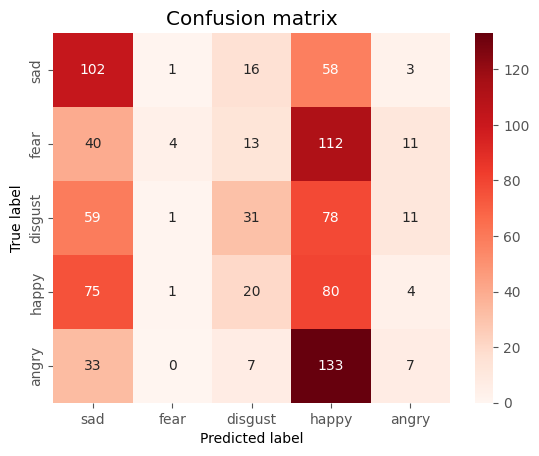

In [19]:
##CNN - LSTM
print(load_model_cnnlstm.predict(X))
y_pred = np.argmax(load_model_cnnlstm.predict(X), axis=1)
y_true = np.argmax(Y, axis=1)
labels = ['sad', 'fear', 'disgust', 'happy', 'angry']
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

accuracy

0.24888888888888888

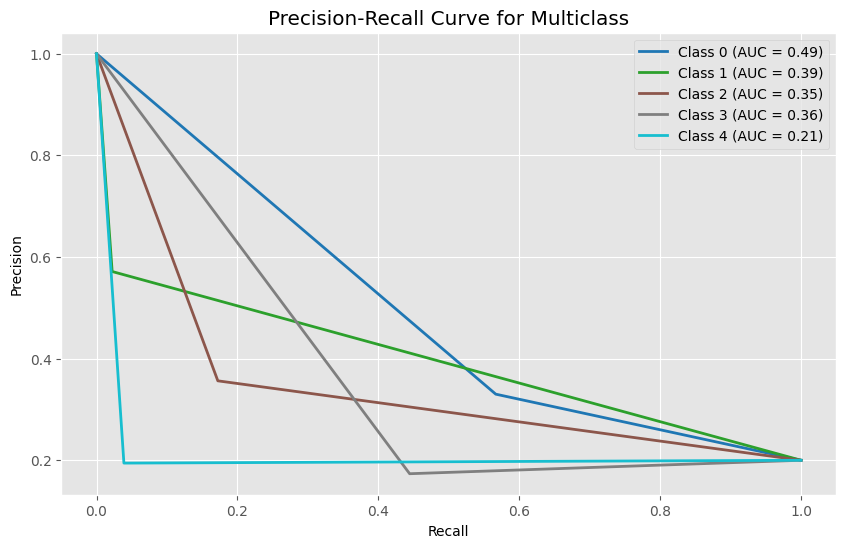

In [21]:
# plot precison recall metrices for cnn attention model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


# Example data (replace this with your actual data)
y_true = np.array(y_true)
y_scores = np.array(y_pred)

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
average_precision = dict()

n_classes = y_true_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# ANN 

29/29 [==============================] - 0s 2ms/step
[[2.3875538e-02 7.3999546e-02 1.5982758e-05 9.0210891e-01 7.9204410e-10]
 [5.3327203e-01 5.1242962e-02 2.2270648e-01 1.9213447e-01 6.4404128e-04]
 [7.4959576e-01 1.1789343e-02 9.8637200e-04 2.3761965e-01 8.8148636e-06]
 ...
 [2.3241424e-04 9.4158977e-01 4.0629625e-06 5.1334017e-04 5.7660498e-02]
 [5.7194452e-03 9.4995165e-01 1.2574416e-05 2.3672461e-04 4.4079632e-02]
 [4.8784600e-04 6.5237336e-02 5.1166457e-01 2.7333546e-02 3.9527664e-01]]
29/29 [==============================] - 0s 2ms/step


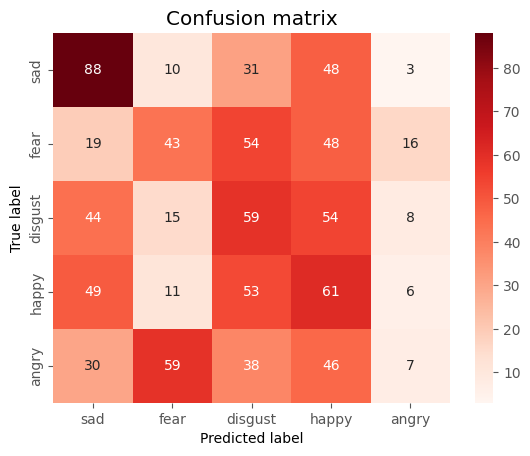

In [22]:
#ann
print(load_model_ann.predict(X))
y_pred = np.argmax(load_model_ann.predict(X), axis=1)
y_true = np.argmax(Y, axis=1)
labels = ['sad', 'fear', 'disgust', 'happy', 'angry']
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()


In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

accuracy

0.2866666666666667

# More layers added in ANN

29/29 [==============================] - 0s 1ms/step
[[8.9006281e-01 5.8260154e-02 1.1651248e-03 5.0511591e-02 3.6369346e-07]
 [8.4975249e-01 5.6764815e-04 1.0044657e-01 4.9233183e-02 6.5752793e-08]
 [4.1968021e-01 3.8610138e-02 1.2389951e-01 4.1754520e-01 2.6501165e-04]
 ...
 [2.6006748e-05 9.9996686e-01 1.5455217e-07 5.8796813e-06 1.1308630e-06]
 [6.9417132e-05 9.9989867e-01 1.2301180e-06 2.2187243e-05 8.4893018e-06]
 [8.9592449e-03 2.8473613e-01 1.6673924e-01 3.1182883e-02 5.0838244e-01]]
29/29 [==============================] - 0s 2ms/step


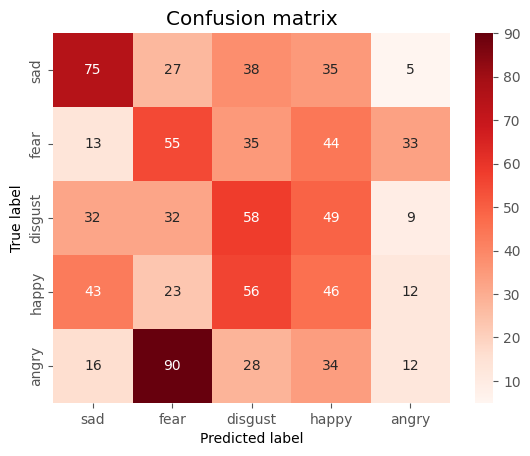

In [24]:
# more ann
print(load_model_more_ann.predict(X))
y_pred = np.argmax(load_model_more_ann.predict(X), axis=1)
y_true = np.argmax(Y, axis=1)
labels = ['sad', 'fear', 'disgust', 'happy', 'angry']
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()


In [25]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

accuracy

0.2733333333333333

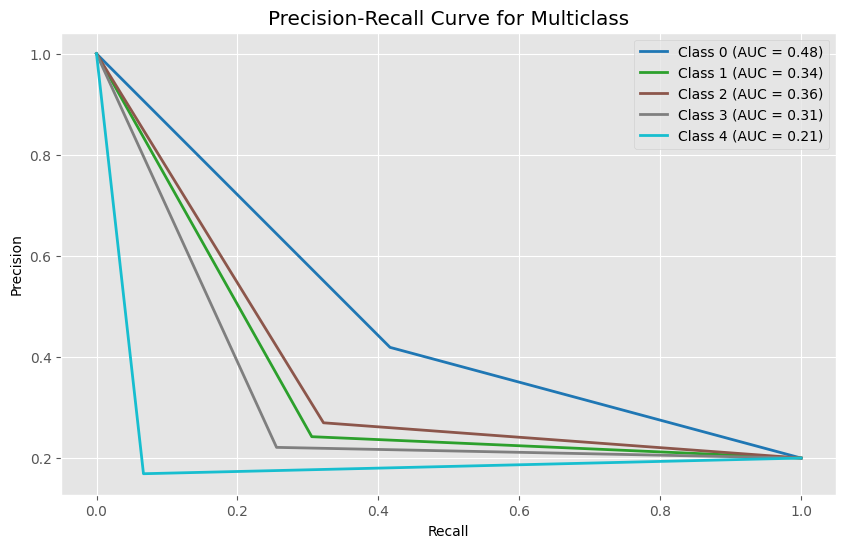

In [26]:
# plot precison recall metrices for cnn attention model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


# Example data (replace this with your actual data)
y_true = np.array(y_true)
y_scores = np.array(y_pred)

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
average_precision = dict()

n_classes = y_true_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Combo of ann and lstm

29/29 [==============================] - 2s 46ms/step
[[7.6329422e-01 2.6375344e-02 4.8099913e-02 1.6222954e-01 1.0255750e-06]
 [1.3195415e-01 1.7670969e-03 7.9312164e-01 7.3132090e-02 2.5022908e-05]
 [1.8717396e-01 2.7724472e-01 1.7910548e-01 3.2947290e-01 2.7002959e-02]
 ...
 [1.4515576e-01 3.9259240e-01 3.2114029e-01 1.3411097e-01 7.0006540e-03]
 [1.0364603e-03 2.1837160e-01 1.2767635e-01 1.6769577e-02 6.3614601e-01]
 [7.2130448e-01 3.1982783e-02 1.7643473e-01 7.0235506e-02 4.2516640e-05]]
29/29 [==============================] - 1s 48ms/step


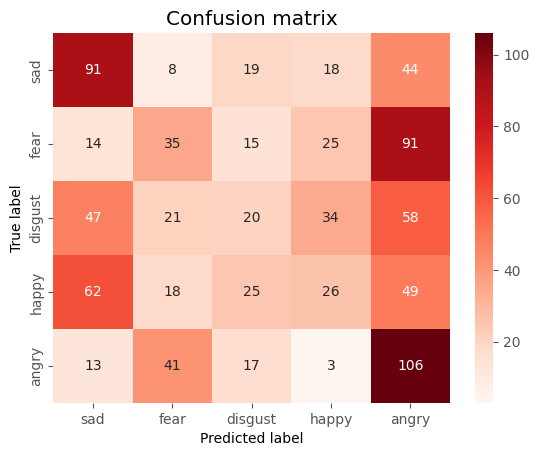

In [27]:
##ann-lstm
print(load_model_annlstm.predict(X))
y_pred = np.argmax(load_model_annlstm.predict(X), axis=1)
y_true = np.argmax(Y, axis=1)
labels = ['sad', 'fear', 'disgust', 'happy', 'angry']
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

accuracy

0.3088888888888889

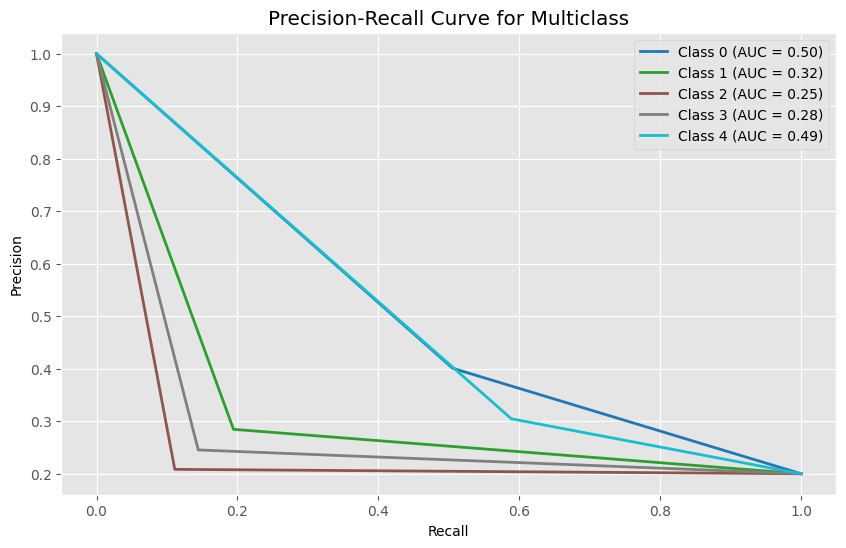

In [29]:
# plot precison recall metrices for cnn attention model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


# Example data (replace this with your actual data)
y_true = np.array(y_true)
y_scores = np.array(y_pred)

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
average_precision = dict()

n_classes = y_true_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# ann plus more layers of lstm

29/29 [==============================] - 2s 45ms/step
[[0.25487816 0.06451617 0.28815714 0.37376946 0.01867904]
 [0.22709899 0.11906009 0.18097691 0.45024982 0.02261411]
 [0.00764623 0.07596488 0.38376704 0.22270986 0.30991197]
 ...
 [0.29442823 0.09417378 0.26326123 0.27746657 0.07067017]
 [0.02778637 0.06009062 0.52498144 0.12702554 0.26011604]
 [0.00389733 0.08465325 0.24075203 0.47254184 0.19815554]]
29/29 [==============================] - 1s 48ms/step


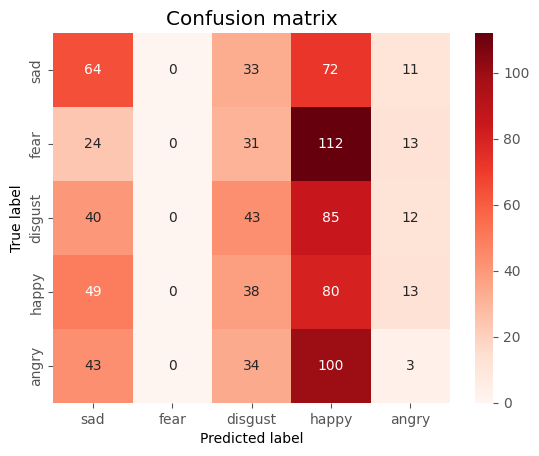

In [30]:
##ann -more - lstm
print(load_model_annmorelstm.predict(X))
y_pred = np.argmax(load_model_annmorelstm.predict(X), axis=1)
y_true = np.argmax(Y, axis=1)
labels = ['sad', 'fear', 'disgust', 'happy', 'angry']
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

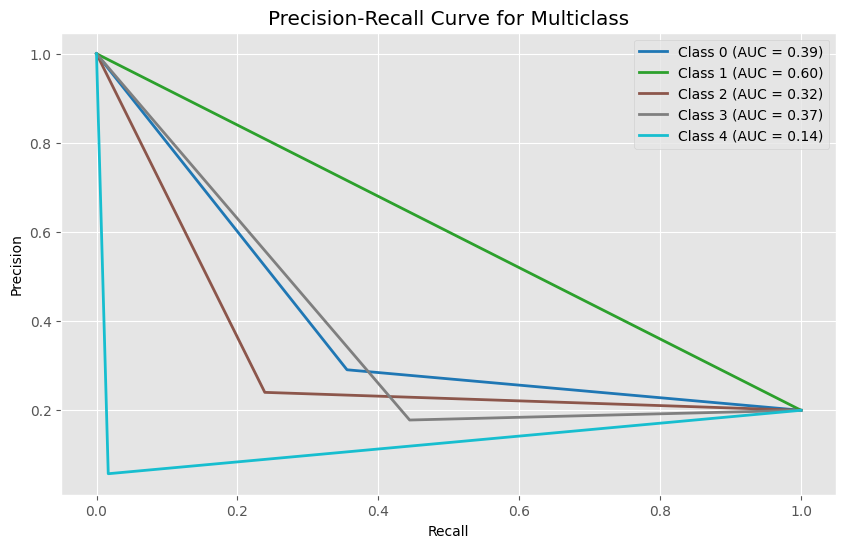

In [31]:
# plot precison recall metrices for cnn attention model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


# Example data (replace this with your actual data)
y_true = np.array(y_true)
y_scores = np.array(y_pred)

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
average_precision = dict()

n_classes = y_true_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# results 

the best model we found was a combination of ann and lstm layers---> 60% training accuracy and 32 % testing accuracy

In [36]:
#for testing run this
import pickle
from collections import Counter


import librosa
import numpy as np
from pydub import AudioSegment, effects

file_path = "./Crema/1001_DFA_SAD_XX.wav"
label_dict = {
    "sad" : 0,
    "fear" : 1,
    "disgust" : 2,
    "happy" : 3,
    "angry" : 4
}

scalar_path = "./scalar"
with open(scalar_path, 'rb') as scalar_file:
    scalar = pickle.load(scalar_file)

def classify_audio(file_path):
    X_test = []
    feature = get_features(file_path)
    for ele in feature:
        X_test.append(ele)
    Features = pd.DataFrame(X_test)
    X = Features.iloc[: ,:-1].values
    print(X.shape)
    X = scalar.fit_transform(X)
    X  = np.expand_dims(X, axis=2)
    print(load_model_annlstm.predict(X))
    y_pred = np.argmax(load_model_annlstm.predict(X), axis=1)
    y_pred_mapped = [key for y_pred_item in y_pred for key, value in label_dict.items() if value == y_pred_item]
    print(y_pred_mapped)
    emotion_counts = Counter(y_pred_mapped)
    max_emotion = max(emotion_counts, key=emotion_counts.get)
    print(max_emotion)


classify_audio(file_path=file_path)


1/1 [==============================] - 0s 40ms/step
sad
